In [1]:
import pyspark
from pyspark import SparkFiles
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import rand, col

import os
import math
import time
import operator
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.mllib.evaluation import RankingMetrics
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit

seed = 100
sc = SparkContext()
filePath = "/home/jovyan/work/Personalization/ml-20m/ratings.csv"

### Data Preprocessing

In [2]:
# read dataset into spark RDD
sc.addFile(filePath)
sqlContext = SQLContext(sc)
df = sqlContext.read.csv(SparkFiles.get("ratings.csv"), header=True, inferSchema=True)

sqlContext.registerDataFrameAsTable(df, "df")
df = sqlContext.sql('''
    SELECT 
        userId AS user, 
        movieId AS item,
        rating
    FROM df
''')

In [3]:
# adding uniform random numbers for train/validation/test set
df = df.withColumn('TrainTest', rand(seed=seed))
print("(row, col): ", (df.count(), len(df.columns)))

(row, col):  (20000263, 4)


In [4]:
result = {}

### Metrics

In [6]:
# primary metric - RMSE
# secondary metric - MAE
rmse = RegressionEvaluator(metricName="rmse", labelCol="rating")
mae = RegressionEvaluator(metricName="mae", labelCol="rating")

### Models

In [9]:
for splitSize in [0.001, 0.01, 0.1, 0.3, 0.5]:
    start = time.time()
    dftrain = df.where(col('TrainTest') < splitSize).drop(*["TrainTest"])
    trainSize = dftrain.count()
    print("(row, col): ", (trainSize, len(dftrain.columns)))
    
    
    dftest = df.where(col('TrainTest') > splitSize).drop(*["TrainTest"])
    testSize = dftest.count()
    print("(row, col): ", (testSize, len(dftest.columns)))
    
    
    als = ALS(nonnegative=True, checkpointInterval=3, coldStartStrategy="drop")
    paramGrid = ParamGridBuilder() \
        .addGrid(als.rank, [5]) \
        .addGrid(als.regParam, [0.1]) \
        .build()

    
    tvs = TrainValidationSplit(
        estimator=als,
        estimatorParamMaps=paramGrid,
        evaluator=rmse,
        seed=seed,
        trainRatio=0.66, # this ratio makes train:0.5 valid:0.25 and test:0.25
        parallelism=3
    )
    
    
    model = tvs.fit(dftrain)
    model_path = os.getcwd() + '/training_models/ALS_splitSize-' + str(splitSize)
    model.save(model_path)
    testPred = model.transform(dftest)
    trainPred = model.transform(dftrain)
    
    end = time.time()
    
    result[splitSize] = {
        "time": end-start, 
        "rmseTrain": rmse.evaluate(trainPred),
        "rmseTest": rmse.evaluate(testPred), 
        "maeTrain": mae.evaluate(trainPred),
        "maeTest": mae.evaluate(testPred),
        "trainSize": trainSize,
        "testSize": testSize
    }
    
    print("split size=%s rmse=%s" % (splitSize, result[splitSize]["rmseTest"]))
    print("used time: %s" % str(result[splitSize]["time"]))
    print("="*20)

(row, col):  (20029, 3)
(row, col):  (19980234, 3)
split size=0.001 rmse=2.045412820550103
used time: 53.50555992126465
(row, col):  (200171, 3)
(row, col):  (19800092, 3)
split size=0.01 rmse=1.294935565293987
used time: 59.30461382865906
(row, col):  (2000203, 3)
(row, col):  (18000060, 3)
split size=0.1 rmse=0.91269784426341
used time: 68.80400776863098
(row, col):  (5998960, 3)
(row, col):  (14001303, 3)
split size=0.3 rmse=0.841881084523025
used time: 79.24481439590454
(row, col):  (9998144, 3)
(row, col):  (10002119, 3)
split size=0.5 rmse=0.8284786196585116
used time: 87.1703610420227


In [10]:
result

{0.001: {'time': 53.50555992126465,
  'rmseTrain': 0.24784831232605817,
  'rmseTest': 2.045412820550103,
  'maeTrain': 0.1103483664959117,
  'maeTest': 1.715422219599787,
  'trainSize': 20029,
  'testSize': 19980234},
 0.01: {'time': 59.30461382865906,
  'rmseTrain': 0.34716467599402473,
  'rmseTest': 1.294935565293987,
  'maeTrain': 0.2551737231608138,
  'maeTest': 1.0188488449024262,
  'trainSize': 200171,
  'testSize': 19800092},
 0.1: {'time': 68.80400776863098,
  'rmseTrain': 0.7100818214813067,
  'rmseTest': 0.91269784426341,
  'maeTrain': 0.551099093564924,
  'maeTest': 0.7071336801969518,
  'trainSize': 2000203,
  'testSize': 18000060},
 0.3: {'time': 79.24481439590454,
  'rmseTrain': 0.7758295044778819,
  'rmseTest': 0.841881084523025,
  'maeTrain': 0.6071187542031499,
  'maeTest': 0.6567119307059291,
  'trainSize': 5998960,
  'testSize': 14001303},
 0.5: {'time': 87.1703610420227,
  'rmseTrain': 0.7903714860579033,
  'rmseTest': 0.8284786196585116,
  'maeTrain': 0.61772531980

### Visualization

In [11]:
import pickle
with open(os.getcwd() + '/result.pkl', 'wb') as f:
    pickle.dump(result, f)

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Text(0, 0.5, 'Running Time (seconds)')

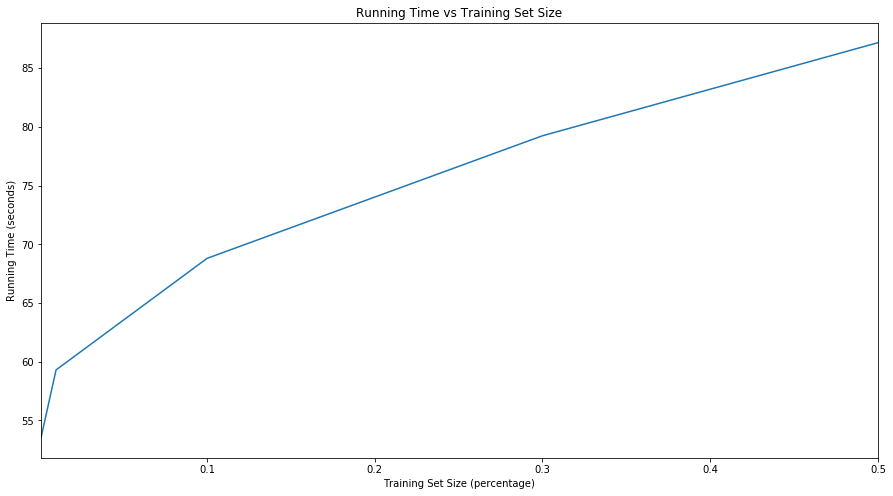

In [13]:
pd.DataFrame(result).T['time'].plot(
    figsize=(15, 8),
    title="Running Time vs Training Set Size"
)
plt.xlabel('Training Set Size (percentage)')
plt.ylabel('Running Time (seconds)')

Text(0, 0.5, 'RMSE')

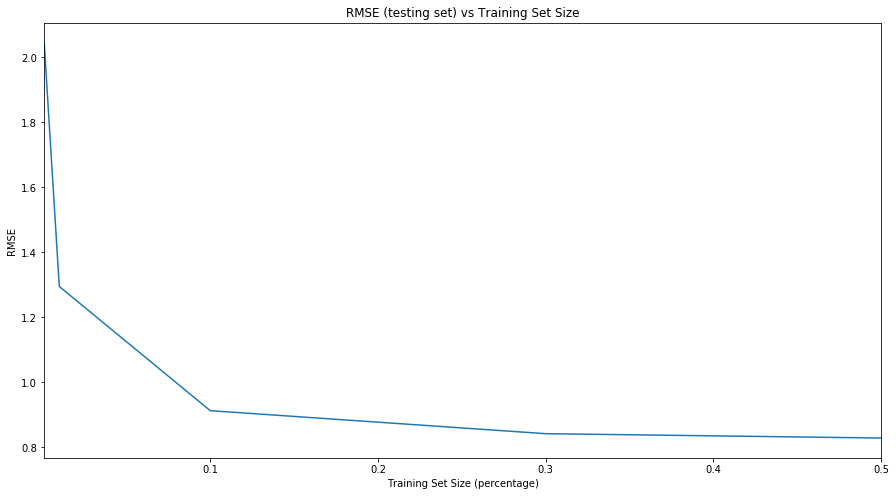

In [14]:
pd.DataFrame(result).T['rmseTest'].plot(
    figsize=(15, 8),
    title="RMSE (testing set) vs Training Set Size"
)
plt.xlabel("Training Set Size (percentage)")
plt.ylabel("RMSE")

### Baseline

In [16]:
# using average rate as Baseline model
meanRating = dftrain.union(dftest).rdd.map(lambda x: x[2]).mean()

In [21]:
baselineRmse = math.sqrt(
    dftest.rdd.map(lambda x: (meanRating - x[2]) ** 2).reduce(operator.add) / dftest.count()
)

In [23]:
print("baseline performance on test set: ", baselineRmse)
print("ALS performance on test set: ", result[0.5]['rmseTest'])

baseline performance on test set:  1.0519832166584029
ALS performance on test set:  0.8284786196585116
